In [1]:
%matplotlib inline 

# Association Rule Mining
***

## Table of Contents
***
* [Aim](#aim)
* [Code Setup](#code-setup)
* [Data Import](#data-import)
* [Product Investigation](#product)
* [Aisle Investigation](#aisle)
* [Department Investigation](#department)

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to perform Association Rule Mining on the Instacart Data. Note no quantity of item analysis is complete, only a one hot whether an item appears or not.

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Constants

In [2]:
instacart_dir = "instacart_2017_05_01/"
my_orders_file = "my_orders.csv"
products_file = "products.csv"
aisles_file = "aisles.csv"
departments_file = "departments.csv"
orders_products_prior_file = "my_order_products__prior.csv"
orders_products_train_file = "my_order_products__train.csv"

### Import Libraries

In [3]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [4]:
te = TransactionEncoder()

In [5]:
def read_csv_file(file_name):
    return pd.read_csv(instacart_dir + file_name)

In [6]:
orders = read_csv_file(my_orders_file)
orders.head()

,Unnamed: 0,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12202,472199,765,prior,1,2,21,NaN
1,12203,1424394,765,prior,2,1,21,20.0
2,12204,889292,765,prior,3,6,21,30.0
3,12205,2809253,765,prior,4,3,20,30.0
4,12206,2392861,765,prior,5,1,12,19.0


In [7]:
orders_products_prior = read_csv_file(orders_products_prior_file)
orders_products_train = read_csv_file(orders_products_train_file)
orders_products = pd.concat([orders_products_prior, orders_products_train])
orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,147221,15511,429,1,0
1,147222,15511,46397,2,0
2,147223,15511,27323,3,0
3,147224,15511,28842,4,1
4,147225,15511,4605,5,0


In [8]:
products = read_csv_file(products_file)
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
departments = read_csv_file(departments_file)
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
aisles = read_csv_file(aisles_file)
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## Product Investigation <a class="anchor" id="product"></a>
***

### Product Number Counts

In [11]:
product_order_frequency = (orders_products
                           .groupby("product_id")
                           .size()
                           .reset_index(name="count")
                           .sort_values(by=['count'], ascending=False)
                          )
order_count_total = orders.shape[0]
print("Total Orders :", order_count_total)
max_product_count = product_order_frequency["count"].max()
min_product_count = product_order_frequency["count"].min()
print("Product Order Count Max :", max_product_count)
print("Product Order Count Min :", min_product_count)
mean_order_frequency = round(product_order_frequency["count"].mean())
print("Product Order Count Average :", mean_order_frequency)
print("Product Order Count Median :", product_order_frequency["count"].median())
print("Product Order Count Mode :", product_order_frequency["count"].mode()[0])

Total Orders : 306
Product Order Count Max : 67
Product Order Count Min : 1
Product Order Count Average : 3.0
Product Order Count Median : 1.0
Product Order Count Mode : 1


### Grouping Products in an Order

In [12]:
# Can't just use a comma as a seperator
weird_separator = ",#,"
def products_ordered_to_total(products_ordered):
    group = products_ordered.groupby('order_id')
    product_count = group.size().reset_index(name="count")
    product_names = group["product_name"].apply(lambda x: "%s" % weird_separator.join(x)).reset_index(name="products")
    products_ordered_total = (product_count.merge(product_names, on="order_id"))
    return products_ordered_total
products_ordered = orders_products.merge(products, on="product_id")
products_ordered_total = products_ordered_to_total(products_ordered)
order_total = products_ordered_total.shape[0]
products_ordered_total.head()

,order_id,count,products
0,15511,13,"Dark Red Kidney Beans,#,Reduced Sodium Great N..."
1,22082,3,"Organic Extra Large Brown Eggs,#,Organic Fruit..."
2,26712,14,"Gluten Free Breaded Chicken Breast Tenders,#,1..."
3,27068,14,"Yellow Onions,#,Red Peppers,#,Yellow Bell Pepp..."
4,49162,9,"Bunched Cilantro,#,Red Peppers,#,Yellow Bell P..."


### Product - Calculate Decent Support Value

In [13]:
# For support values
# Suck it and see approach to get min desired appearance
min_desired_times_ordered = 10
min_support = round(min_desired_times_ordered/order_total, 4)
print("Minimum times ordered to be considered :", min_desired_times_ordered)
print("Minimum Support :", min_support)

Minimum times ordered to be considered : 10
Minimum Support : 0.0331


### Product - Transaction Database Boolean Array

In [14]:
def product_list_to_te_df(product_list):
    products_ordered_list_of_lists = []
    for p in product_list:
        products_ordered_list_of_lists.append(p.split(weird_separator))
    te_ary = te.fit(products_ordered_list_of_lists).transform(products_ordered_list_of_lists,sparse=False)
    te_df = pd.DataFrame(te_ary, columns=te.columns_)
    return te_df
te_df = product_list_to_te_df(products_ordered_total.products.tolist())
te_df.head()

,1% Low Fat Chocolate Milk,100 Calorie Per Bag Popcorn,100% All Cranberry Juice,100% Colombian Medium Dark Roast Ground Coffee,100% Cranberry Juice,100% Grapeseed Oil,100% Liquid Egg Whites,100% Natural Sweetener Zero Calorie Packets,100% Oatnut Bread,100% Pure Cotton Ovals,...,Yellow Peaches,YoBaby Peach Pear Yogurt,"YoKids Squeezers Organic Low-Fat Yogurt, Strawberry",Yobaby Organic Plain Yogurt,Yogurt Tubes Blueberry,Yukon Gold Potatoes 5lb Bag,Z Bar Protein Peanut Butter Chocolate Protein Snack Bar,ZBar Organic Chocolate Brownie Energy Snack,Zero Soda,gel hand wash sea minerals
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Product - First 100 transactions vs items

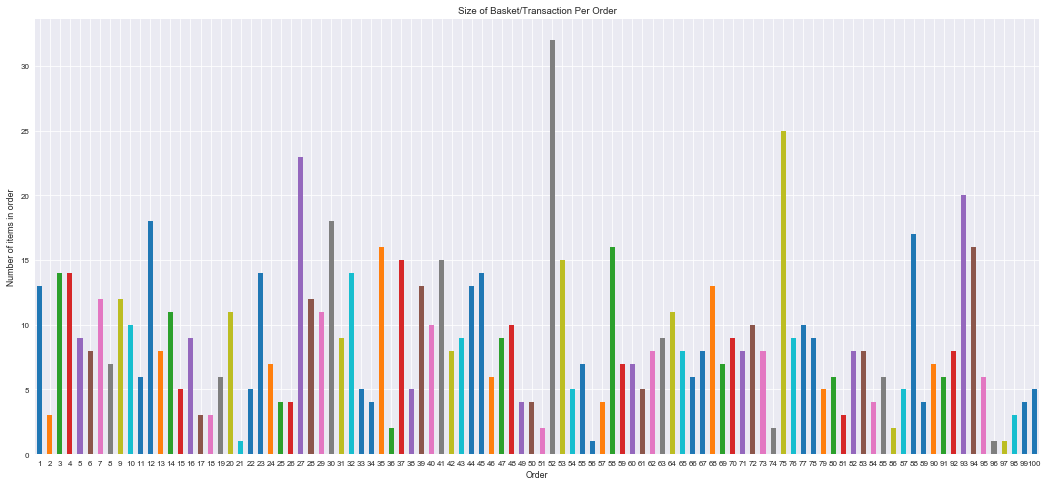

In [15]:
limit = 100
the_range = list(range(1, limit + 1))
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
products_ordered_total["count"].head(limit).plot.bar()
ax.set_xticklabels(the_range, rotation='horizontal')
plt.title("Size of Basket/Transaction Per Order")
plt.ylabel("Number of items in order")
plt.xlabel("Order")
plt.show()

Bat plot may not bes illustrate this but does sho that the number of items per transactions fluctuates between 1 and 33 for the first 100 transactions.

### Product - Distribution of Transaction size

In [16]:
# Generate plot of count of the number of transactions of the same size
a = (products_ordered_total[["count"]]
     .groupby("count")
     .size()
     .reset_index(name="counts")
     .sort_values(by="counts", ascending=False)
    )
a.head()

,count,counts
8,9,28
4,5,25
7,8,22
9,10,22
2,3,21


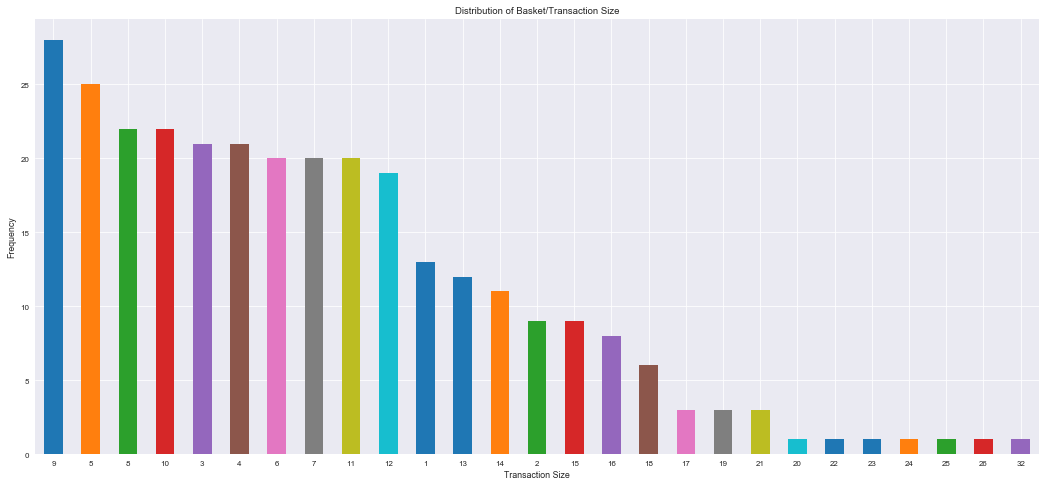

In [17]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(18)
a['counts'].plot.bar()
ax.set_xticklabels(a["count"], rotation='horizontal')
plt.title("Distribution of Basket/Transaction Size")
plt.ylabel("Frequency")
plt.xlabel("Transaction Size")
plt.show()

The most often number of items ordered is 9 followed by 5, then 8. From a speculation perspective I would have though that between 1 and 3 items would have been more frequent with the logic that people buy small amount of items online often.

### Product - Frequent Itemsets - Apriori

In [18]:
frequent_itemsets = (apriori(te_df, min_support=min_support,use_colnames=True)
     .sort_values(by='support',ascending=False))
print("Number of frequent itemsets generated via Apriori with over ", min_support, " support :" , frequent_itemsets.shape[0])
frequent_itemsets.head()

Number of frequent itemsets generated via Apriori with over  0.0331  support : 121


,support,itemsets
1,0.221854,[2% Reduced Fat Organic Milk]
46,0.175497,[Vanilla Almond Breeze]
64,0.165563,"[2% Reduced Fat Organic Milk, Vanilla Almond B..."
11,0.139073,[Granny Smith Apples]
2,0.129139,[Banana]


### Product - Support for most Frequeny products

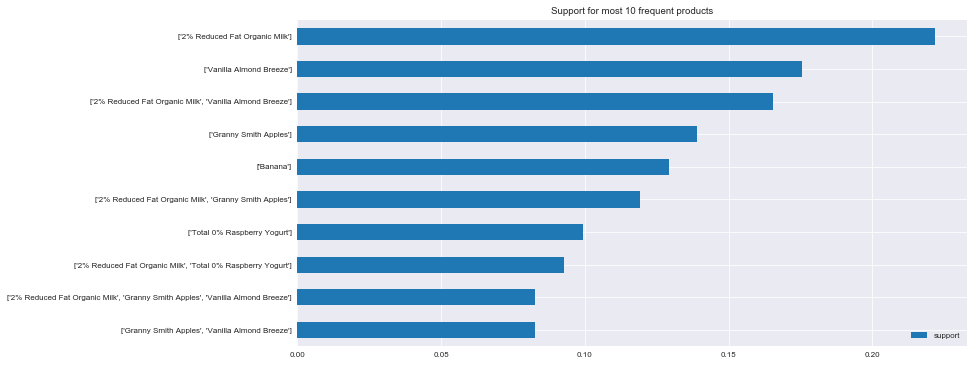

In [19]:
min_numer_to_show = 10
frequent_itemsets.head(min_numer_to_show).plot.barh(title ="Support for most " + str(min_numer_to_show) +  " frequent products")
plt.yticks(range(min_numer_to_show), frequent_itemsets["itemsets"].head(min_numer_to_show))
plt.gca().invert_yaxis()
plt.show()

### Product Rule Generation

####  Rule Generation by Lift

In [20]:
min_lift = 5
lift_rules = (association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        .sort_values(by=['confidence', 'support', 'lift'],ascending=False))
print ("Number of Generated Rules via lift :", lift_rules.shape[0], " min value of lift : ", min_lift)
lift_rules.head(10)

Number of Generated Rules via lift : 154  min value of lift :  5


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
38,"(2% Reduced Fat Organic Milk, Total 2% Greek S...",(Vanilla Almond Breeze),0.043046,0.175497,0.043046,1.000000,5.698113,0.035492,inf
85,"(Vanilla Almond Breeze, Total 2% Lowfat Greek ...","(2% Reduced Fat Organic Milk, Total 0% Raspber...",0.039735,0.092715,0.039735,1.000000,10.785714,0.036051,inf
77,"(Vanilla Almond Breeze, Total 2% Lowfat Greek ...",(Total 0% Raspberry Yogurt),0.039735,0.099338,0.039735,1.000000,10.066667,0.035788,inf
81,"(2% Reduced Fat Organic Milk, Vanilla Almond B...",(Total 0% Raspberry Yogurt),0.039735,0.099338,0.039735,1.000000,10.066667,0.035788,inf
48,"(2% Reduced Fat Organic Milk, Total 2% Greek S...",(Vanilla Almond Breeze),0.039735,0.175497,0.039735,1.000000,5.698113,0.032762,inf
108,(Premium Lager Beer),(Lager),0.036424,0.039735,0.036424,1.000000,25.166667,0.034977,inf
13,(Total 2% Lowfat Greek Strained Yogurt With Bl...,(Total 0% Raspberry Yogurt),0.052980,0.099338,0.049669,0.937500,9.437500,0.044406,14.410596
17,"(2% Reduced Fat Organic Milk, Total 2% Lowfat ...",(Total 0% Raspberry Yogurt),0.049669,0.099338,0.046358,0.933333,9.395556,0.041424,13.509934
28,(Total 2% Greek Strained Yogurt with Cherry 5....,(Total 0% Raspberry Yogurt),0.046358,0.099338,0.043046,0.928571,9.347619,0.038441,12.609272
40,(Total 2% Greek Strained Yogurt with Cherry 5....,"(2% Reduced Fat Organic Milk, Vanilla Almond B...",0.046358,0.165563,0.043046,0.928571,5.608571,0.035371,11.682119


Premium lager and normal lager bought together, not very interesting. Yogurt and low fat products bought together also not very interesting. Need to roll up the organic items into an organic category

#### Rule Generation by Confidence

In [21]:
min_conf = 0.8
conf_rules = (association_rules(frequent_itemsets, metric="confidence", min_threshold=min_conf)
        .sort_values(by=['confidence', 'support', 'lift'],ascending=False))
print ("Number of Generated Rules via confidence :", conf_rules.shape[0], " min confidence :", min_conf)
conf_rules.head(10)

Number of Generated Rules via confidence : 85  min confidence : 0.8


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3,"(Granny Smith Apples, Vanilla Almond Breeze)",(2% Reduced Fat Organic Milk),0.082781,0.221854,0.082781,1.0,4.507463,0.064416,inf
5,"(Total 0% Raspberry Yogurt, Vanilla Almond Bre...",(2% Reduced Fat Organic Milk),0.076159,0.221854,0.076159,1.0,4.507463,0.059263,inf
8,(Cherry Pomegranate Greek Yogurt),(2% Reduced Fat Organic Milk),0.056291,0.221854,0.056291,1.0,4.507463,0.043803,inf
13,"(Granny Smith Apples, Cherry Pomegranate Greek...",(2% Reduced Fat Organic Milk),0.049669,0.221854,0.049669,1.0,4.507463,0.038650,inf
26,"(2% Reduced Fat Organic Milk, Total 2% Greek S...",(Vanilla Almond Breeze),0.043046,0.175497,0.043046,1.0,5.698113,0.035492,inf
22,"(Granny Smith Apples, Total 0% Raspberry Yogur...",(2% Reduced Fat Organic Milk),0.043046,0.221854,0.043046,1.0,4.507463,0.033496,inf
25,"(Total 0% Raspberry Yogurt, Cherry Pomegranate...",(2% Reduced Fat Organic Milk),0.043046,0.221854,0.043046,1.0,4.507463,0.033496,inf
27,(Total 2% Greek Strained Yogurt with Cherry 5....,(2% Reduced Fat Organic Milk),0.043046,0.221854,0.043046,1.0,4.507463,0.033496,inf
29,"(Fat Free Strawberry Yogurt, Vanilla Almond Br...",(2% Reduced Fat Organic Milk),0.043046,0.221854,0.043046,1.0,4.507463,0.033496,inf
57,"(Vanilla Almond Breeze, Total 2% Lowfat Greek ...","(2% Reduced Fat Organic Milk, Total 0% Raspber...",0.039735,0.092715,0.039735,1.0,10.785714,0.036051,inf


Very similar results as using the min lift

### Product - Organic Rollup Attempt

In [22]:
orders_products.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,147221,15511,429,1,0
1,147222,15511,46397,2,0
2,147223,15511,27323,3,0
3,147224,15511,28842,4,1
4,147225,15511,4605,5,0


In [23]:
orders_products_product_details = orders_products.merge(products, on="product_id")
orders_products_product_details.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,147221,15511,429,1,0,Dark Red Kidney Beans,59,15
1,147222,15511,46397,2,0,Reduced Sodium Great Northern Beans,59,15
2,147223,15511,27323,3,0,Pure & Natural Sour Cream,108,16
3,2527915,266611,27323,7,0,Pure & Natural Sour Cream,108,16
4,147224,15511,28842,4,1,Bunched Cilantro,16,4


### Organic Products

In [24]:
# Took this approach as this was less computation than using the full products list
organic_products_ordered = orders_products_product_details[orders_products_product_details['product_name'].str.contains("Organic")]
print("Organic Products Ordered :", organic_products_ordered.shape[0])
organic_products_ordered.head()

Organic Products Ordered : 648


,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
49,253765,26712,32467,9,0,Organic Living Butter Lettuce,83,4
50,253766,26712,27625,10,0,Organic Lady Alice Apples,24,4
53,253769,26712,18811,13,0,Organic Apple Juice,98,7
92,257079,27068,890,3,0,Organic Diced Tomatoes,81,15
93,4575555,482965,890,24,0,Organic Diced Tomatoes,81,15


In [25]:
organic_products_ordered_aisle = organic_products_ordered.merge(aisles, on="aisle_id")
organic_products_ordered_aisle.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
0,253765,26712,32467,9,0,Organic Living Butter Lettuce,83,4,fresh vegetables
1,257080,27068,24964,4,0,Organic Garlic,83,4,fresh vegetables
2,4575554,482965,24964,23,1,Organic Garlic,83,4,fresh vegetables
3,5434953,573593,24964,10,0,Organic Garlic,83,4,fresh vegetables
4,9423698,994761,24964,4,1,Organic Garlic,83,4,fresh vegetables


### Product Rollup Note
Below is my product roll up procedure which is not very smart as it takes each item very specifically such as organic, or yogurt are specifically coded for, the only smart way I could think of rolling items up is by aisle but as this will be investigated later I did not see the point in doing that now.

### The organic rollup logic - probably not very efficient

In [26]:
orders_products_product_details_organic_rollup = orders_products_product_details.copy()
aisle_id_list = organic_products_ordered_aisle.aisle_id.unique().tolist()
for aisle_id in aisle_id_list :
    df = organic_products_ordered_aisle.query("aisle_id == " + str(aisle_id))
    organic_title = "Organic " + df.aisle.unique().tolist()[0]
    for index, row in df.iterrows():
        orders_products_product_details_organic_rollup.loc[orders_products_product_details_organic_rollup['Unnamed: 0'] == row["Unnamed: 0"], 'product_name'] = organic_title
orders_products_product_details_organic_rollup.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,147221,15511,429,1,0,Dark Red Kidney Beans,59,15
1,147222,15511,46397,2,0,Reduced Sodium Great Northern Beans,59,15
2,147223,15511,27323,3,0,Pure & Natural Sour Cream,108,16
3,2527915,266611,27323,7,0,Pure & Natural Sour Cream,108,16
4,147224,15511,28842,4,1,Bunched Cilantro,16,4


In [27]:
organic_rollup_products_total = products_ordered_to_total(orders_products_product_details_organic_rollup)
te_df = product_list_to_te_df(organic_rollup_products_total.products.tolist())
te_df.head()

,1% Low Fat Chocolate Milk,100 Calorie Per Bag Popcorn,100% All Cranberry Juice,100% Colombian Medium Dark Roast Ground Coffee,100% Cranberry Juice,100% Grapeseed Oil,100% Liquid Egg Whites,100% Natural Sweetener Zero Calorie Packets,100% Oatnut Bread,100% Pure Cotton Ovals,...,XL Symphony Candy Bar,Yellow Bell Pepper,Yellow Onions,Yellow Peaches,YoBaby Peach Pear Yogurt,Yogurt Tubes Blueberry,Yukon Gold Potatoes 5lb Bag,Z Bar Protein Peanut Butter Chocolate Protein Snack Bar,Zero Soda,gel hand wash sea minerals
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


From 962 to 816 columns due to the organic rollups

### Product - Rollup the Yogurts

In [28]:
rollup_with_yogurt = orders_products_product_details_organic_rollup.copy()
yogurts_ordered = rollup_with_yogurt[rollup_with_yogurt['product_name'].str.contains("Yogurt")]
for index, row in yogurts_ordered.iterrows():
    rollup_with_yogurt.loc[rollup_with_yogurt['Unnamed: 0'] == row["Unnamed: 0"], 'product_name'] = "Yogurt"
rollup_with_yogurt.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,147221,15511,429,1,0,Dark Red Kidney Beans,59,15
1,147222,15511,46397,2,0,Reduced Sodium Great Northern Beans,59,15
2,147223,15511,27323,3,0,Pure & Natural Sour Cream,108,16
3,2527915,266611,27323,7,0,Pure & Natural Sour Cream,108,16
4,147224,15511,28842,4,1,Bunched Cilantro,16,4


In [29]:
rollup_with_yogurt_total = products_ordered_to_total(rollup_with_yogurt)
te_df = product_list_to_te_df(rollup_with_yogurt_total.products.tolist())
te_df.head()

,1% Low Fat Chocolate Milk,100 Calorie Per Bag Popcorn,100% All Cranberry Juice,100% Colombian Medium Dark Roast Ground Coffee,100% Cranberry Juice,100% Grapeseed Oil,100% Liquid Egg Whites,100% Natural Sweetener Zero Calorie Packets,100% Oatnut Bread,100% Pure Cotton Ovals,...,XL Emerald White Seedless Grapes,XL Symphony Candy Bar,Yellow Bell Pepper,Yellow Onions,Yellow Peaches,Yogurt,Yukon Gold Potatoes 5lb Bag,Z Bar Protein Peanut Butter Chocolate Protein Snack Bar,Zero Soda,gel hand wash sea minerals
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


From 816 to 788 with the yogurt rollup - not a massive gain but yogurt was frequent enough with the association rule

### Product - Remove Milk
As 'organic' milk is a very general and popular item, just going to remove it from the rollup as it would be rare if something interesting is bough with milk

In [30]:
rollup_without_organic_milk = rollup_with_yogurt.copy()
rollup_without_organic_milk = rollup_without_organic_milk[rollup_without_organic_milk.product_name != "Organic milk"]
rollup_without_organic_milk.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,147221,15511,429,1,0,Dark Red Kidney Beans,59,15
1,147222,15511,46397,2,0,Reduced Sodium Great Northern Beans,59,15
2,147223,15511,27323,3,0,Pure & Natural Sour Cream,108,16
3,2527915,266611,27323,7,0,Pure & Natural Sour Cream,108,16
4,147224,15511,28842,4,1,Bunched Cilantro,16,4


In [31]:
rollup_without_organic_milk_total = products_ordered_to_total(rollup_without_organic_milk)
te_df = product_list_to_te_df(rollup_without_organic_milk_total.products.tolist())
te_df.head()

,1% Low Fat Chocolate Milk,100 Calorie Per Bag Popcorn,100% All Cranberry Juice,100% Colombian Medium Dark Roast Ground Coffee,100% Cranberry Juice,100% Grapeseed Oil,100% Liquid Egg Whites,100% Natural Sweetener Zero Calorie Packets,100% Oatnut Bread,100% Pure Cotton Ovals,...,XL Emerald White Seedless Grapes,XL Symphony Candy Bar,Yellow Bell Pepper,Yellow Onions,Yellow Peaches,Yogurt,Yukon Gold Potatoes 5lb Bag,Z Bar Protein Peanut Butter Chocolate Protein Snack Bar,Zero Soda,gel hand wash sea minerals
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


Dropped only one product item so makes sense it would go from 788 to 787 columns

In [32]:
frequent_itemsets = (apriori(te_df, min_support=min_support,use_colnames=True)
     .sort_values(by='support',ascending=False))
print("Number of frequent itemsets generated via Apriori with over ", min_support, " support :" , frequent_itemsets.shape[0])
frequent_itemsets.head()

Number of frequent itemsets generated via Apriori with over  0.0331  support : 73


,support,itemsets
41,0.258278,[Yogurt]
23,0.241722,[Organic fresh vegetables]
36,0.175497,[Vanilla Almond Breeze]
21,0.172185,[Organic fresh fruits]
27,0.155629,[Organic packaged vegetables fruits]


It can be seen that due to the rollup or oganic it is appearing alot in the frequent item sets

In [33]:
min_lift = 1
lift_rules = (association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)
        .sort_values(by=['confidence', 'support', 'lift'],ascending=False))
print ("Number of Generated Rules via lift :", lift_rules.shape[0], " min value of lift : ", min_lift)
lift_rules.head(20)

Number of Generated Rules via lift : 72  min value of lift :  1


,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
44,(Premium Lager Beer),(Lager),0.036424,0.039735,0.036424,1.000000,25.166667,0.034977,inf
47,"(Red Peppers, Organic packaged vegetables fruits)",(Organic fresh vegetables),0.036424,0.241722,0.036424,1.000000,4.136986,0.027619,inf
67,"(Organic eggs, Red Peppers)",(Organic fresh vegetables),0.033113,0.241722,0.033113,1.000000,4.136986,0.025109,inf
26,(Boneless Skinless Chicken Breasts),(Organic fresh vegetables),0.046358,0.241722,0.043046,0.928571,3.841487,0.031841,10.615894
45,(Lager),(Premium Lager Beer),0.039735,0.036424,0.036424,0.916667,25.166667,0.034977,11.562914
8,(Red Peppers),(Organic fresh vegetables),0.076159,0.241722,0.066225,0.869565,3.597379,0.047816,5.813466
36,(Organic canned jarred vegetables),(Organic fresh vegetables),0.046358,0.241722,0.039735,0.857143,3.545988,0.028529,5.307947
58,(Organic juice nectars),(Organic fresh vegetables),0.039735,0.241722,0.033113,0.833333,3.447489,0.023508,4.549669
20,(Organic eggs),(Organic fresh vegetables),0.059603,0.241722,0.049669,0.833333,3.447489,0.035262,4.549669
60,(Yellow Bell Pepper),(Organic fresh vegetables),0.043046,0.241722,0.033113,0.769231,3.182297,0.022707,3.285872


### Product Assication Rule Conclusion
Unfortunately no particularly interesting rules were found, this is probably due to the size of the data set being used, alternatively is also due to the constringent parameters I used. From the non product rollup investigation (both the confidence and lift approach) it is clear that milk and yogurt is bought frequently, this is fairly common in a weekly grocery shop.

From the rollup assication rule there are some very obvious rules such as Lager is bought with more premium lager.

If someone buys Red Peppers and Organic packaged vegetables fruits then they are likely to buy Organic fresh vegetables , again not overly interesting.

The only somewhat interesting rules are perhaps Granny Smith Apples  (with or without Yogurt) is often bough with Almond milk (Vanilla Almond Breeze), makes sense but most of the association rules appear very similar for these 'health' foods.

Again could have rolled up the fruit by the aisle but as the aisle has its own investigation I didn't want to do more or less the same investigation twice.

## Aisle Investigation <a class="anchor" id="aisle"></a>
***

## Department Investigation <a class="anchor" id="department"></a>
***